# IMPORTS

In [ ]:
from keras.utils.np_utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import glob
from skimage.morphology import medial_axis
from skimage import img_as_ubyte
from  scipy import ndimage
from keras.models import load_model
from skimage.morphology import medial_axis, label
import math
from skimage.measure import label, regionprops
import random

# GET IMAGES

## Get zip images (dropbox) 200

In [ ]:
!wget -O data.zip https://www.dropbox.com/s/n6odgiacnysw9qg/benchmarkdataset.zip?dl=0
!unzip /content/data.zip

--2022-06-24 13:57:31--  https://www.dropbox.com/s/n6odgiacnysw9qg/benchmarkdataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/n6odgiacnysw9qg/benchmarkdataset.zip [following]
--2022-06-24 13:57:31--  https://www.dropbox.com/s/raw/n6odgiacnysw9qg/benchmarkdataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6d998a563a6c5d681949170f1d.dl.dropboxusercontent.com/cd/0/inline/Bn2TD1r_fZ-veX94ATcKg3QT1FRuxAhXBxol0us-wFNpYfCIWPIbGEkzzKMhGouQdeFcFLpQQCsgSDbmr-EDxmXizPZLndCrJ1PN6YNxxh5vAXrQD9KisuW_68-M-K9n5D24T-CeMyb4TRh96qyfMiVrvtsJKhbgQ0SheEG6CWWD1A/file# [following]
--2022-06-24 13:57:32--  https://uc6d998a563a6c5d681949170f1d.dl.dropboxusercontent.com/cd/0/inline/Bn2TD1r_fZ-veX94ATcKg3QT1FRuxAhXBxol0us

## Process dataset

In [ ]:
image_directory = "/content/images"
mask_directory =  "/content/masks"

In [ ]:
image_names = glob.glob(f"{image_directory}/*.jpg")
image_names.sort()


image_dataset = []  

for image_name in image_names:   
      image = cv2.imread(image_name, 1)
      image = Image.fromarray(image)
      image_dataset.append(np.array(image))

In [ ]:
mask_names = glob.glob(f"{mask_directory}/*.png")
mask_names.sort()

mask_dataset = [] 

for image_name in mask_names:
        image = cv2.imread(image_name, 0)
        image = np.where(image>0, 255, image)
        image = Image.fromarray(image)
        mask_dataset.append(np.array(image))

In [ ]:
check_all_names = []
for i in range(len(os.listdir(mask_directory))):
  img_name = image_names[i].split("/")[-1]
  mask_name = mask_names[i].split("/")[-1]

  n1 = img_name.split(".")[0]
  n2 = mask_name.split(".")[0]
  check_all_names.append(n1==n2)

all(check_all_names)

True

In [ ]:
#Normalize images
image_dataset = np.array(image_dataset)/255.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

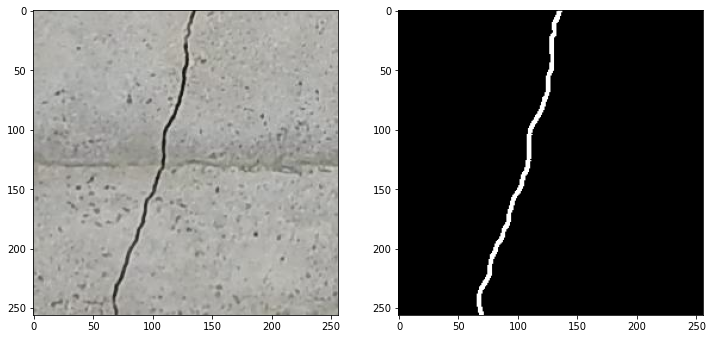

In [ ]:
#Sanity check
image_number = random.randint(0, len(mask_dataset)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (256,256,3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (256,256)), cmap='gray')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.2, random_state = 9)

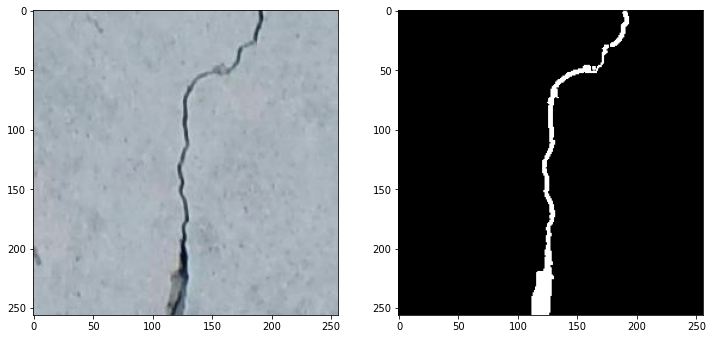

In [ ]:
#Sanity check
image_number = random.randint(0, len(X_test)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_test[image_number], (256,256,3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_test[image_number], (256,256)), cmap='gray')

# LOAD MODELS 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install keras_unet_collection
from keras_unet_collection.transformer_layers import patch_extract, patch_embedding
from keras_unet_collection.activations import GELU

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 6.8 MB/s 


In [ ]:
# BEST MODELS
from tensorflow.keras import backend as K
#U-Net
unet_path = "/content/gdrive/MyDrive/25may/unet.epoch23-dice_coef0.85.hdf5"
unet_model = load_model(unet_path, compile=False)

#Attention U-Net 
att_unet_path = "/content/gdrive/MyDrive/25may/att_unet.epoch33-dice_coef0.83.hdf5" 
att_unet_model = load_model(att_unet_path, compile=False)

#Trans U-Net 
transunet_path = "/content/gdrive/MyDrive/25may/trans_unet.epoch38-dice_coef0.85.hdf5"
transunet_model = load_model(transunet_path, compile=False, custom_objects={"patch_extract": patch_extract, "patch_embedding": patch_embedding, "GELU": GELU})

# #Trans U-Net ResNet50V2
# transunet_resnet_path = "/content/gdrive/MyDrive/keras_unet_collection/trans-unet-resnet/trans_unet_resnet.epoch26-dice_coef0.86.h5"
# transunet_resnet_model = load_model(transunet_resnet_path, compile=False, custom_objects={"patch_extract": patch_extract, "patch_embedding": patch_embedding, "GELU": GELU})

In [ ]:
models = {"unet": unet_model, 
          "att_unet":att_unet_model, 
          "trans_unet":transunet_model,
          # "trans_unet_resnet": transunet_resnet_model
          }

# PREDICTION COMPARISION

analyzing image number: 3


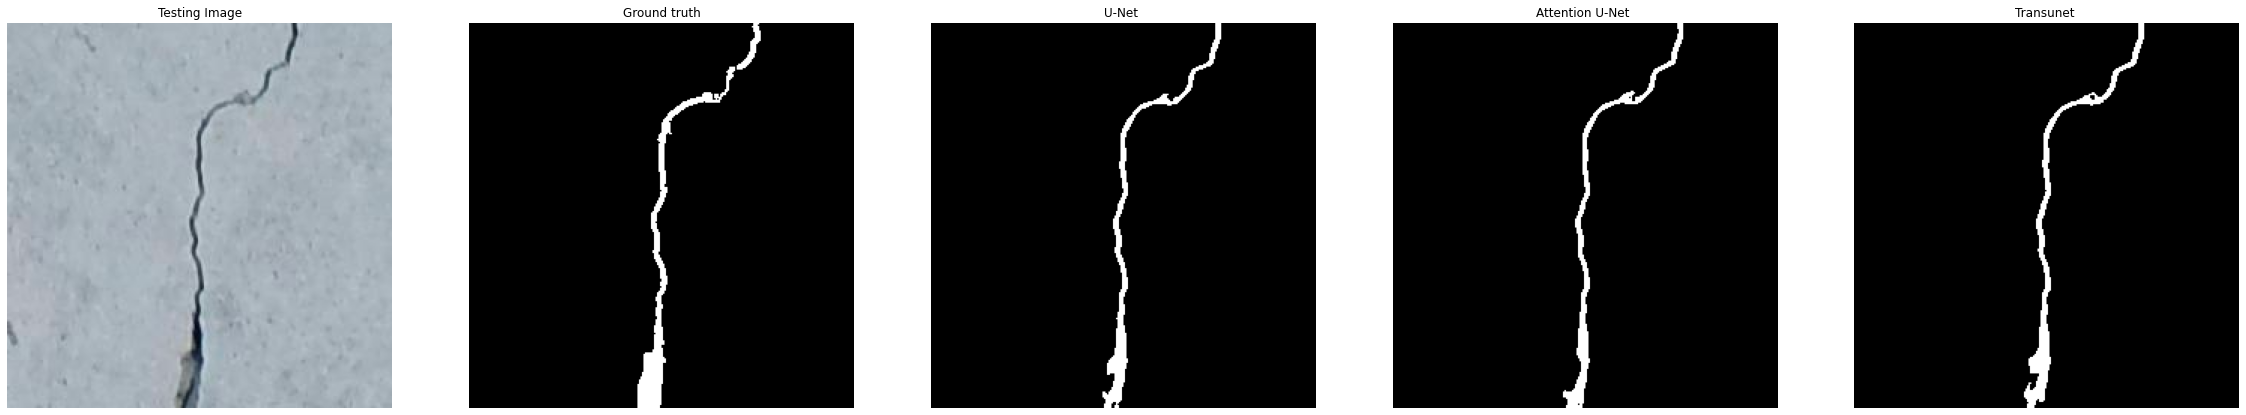

In [ ]:
image_number = random.randint(0, len(mask_dataset)-1)
image_number = 3
print(f"analyzing image number: {image_number}")
threshold = 0.5


#load ground-truth image
image = np.reshape(image_dataset[image_number], (256,256,3))
ground_truth = np.reshape(mask_dataset[image_number], (256,256))


#U-Net 
unet_prediction = (models["unet"].predict(np.expand_dims(image, 0))[0,:,:,0] > threshold).astype(np.uint8)
#Attention U-Net 
attunet_prediction = (models["att_unet"].predict(np.expand_dims(image, 0))[0,:,:,0] > threshold).astype(np.uint8)
#TransUnet 
transunet_prediction = (models["trans_unet"].predict(np.expand_dims(image, 0))[0,:,:,0] > threshold).astype(np.uint8)


plt.figure(figsize=(40, 30))
plt.subplot(151)
plt.axis('off')
plt.title('Testing Image')
plt.imshow(image, cmap='gray')
plt.subplot(152)
plt.axis('off')
plt.title('Ground truth')
plt.imshow(ground_truth, cmap='gray')
plt.subplot(153)
plt.axis('off')
plt.title('U-Net ')
plt.imshow(unet_prediction, cmap='gray')
plt.subplot(154)
plt.axis('off')
plt.title('Attention U-Net ')
plt.imshow(attunet_prediction, cmap='gray')
plt.subplot(155)
plt.axis('off')
plt.title('Transunet ')
plt.imshow(transunet_prediction, cmap='gray')

# BOUNDARY COMPARISION

## utils

In [ ]:
def to_rgb(gray):
    rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)  # rgb just for demo purpose
    return rgb

In [ ]:
def get_boundary(image, gray_value, rgb_value):
  im = image.astype(np.uint8) * 255
  _, crack = cv2.threshold(im, 50, 255, cv2.THRESH_BINARY)

  contour_plot_gray = np.zeros((256,256), np.uint8)
  contour, _ = cv2.findContours(crack, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  cv2.drawContours(contour_plot_gray, contour, -1, gray_value, 1)

  rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # rgb just for demo purpose
  contour_plot_rgb = np.zeros((256,256,3), np.uint8)
  contour_rgb, _ = cv2.findContours(crack, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  cv2.drawContours(contour_plot_rgb, contour_rgb, -1, rgb_value, 1)

  return contour_plot_gray, contour_plot_rgb

In [ ]:
def mask_coloring(mask, pixel_value):
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    color_mask[mask == 1, :] = pixel_value
    return color_mask

In [ ]:
def color_mask_with_boundary(pred, mask_value, boundary_value):

  im = pred.astype(np.uint8) * 255
  _, crack = cv2.threshold(im, 50, 255, cv2.THRESH_BINARY)
  contour_plot_rgb = np.zeros((256,256,3), np.uint8)
  contour_rgb, _ = cv2.findContours(crack, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  cv2.drawContours(contour_plot_rgb, contour_rgb, -1, (10,10,10), 1)

  color_mask = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
  color_mask[pred == 1, :] = (20,20,20)



  combined = color_mask + contour_plot_rgb

  boundary_w_mask = np.zeros((unet_prediction.shape[0], unet_prediction.shape[1],3), dtype=np.uint8)
  for i in range(boundary_w_mask.shape[0]):
    for j in range(boundary_w_mask.shape[1]):
      # print(contour_plot_rgb[i,j,:][0])
      if combined[i,j,:][0] == 20 and combined[i,j,:][1] == 20 and combined[i,j,:][2] == 20:
        boundary_w_mask[i,j,:][0] = mask_value[0]
        boundary_w_mask[i,j,:][1] = mask_value[1]
        boundary_w_mask[i,j,:][2] = mask_value[2]
      if combined[i,j,:][0] == 30 and combined[i,j,:][1] == 30 and combined[i,j,:][2] == 30:
        boundary_w_mask[i,j,:][0] = boundary_value[0]
        boundary_w_mask[i,j,:][1] = boundary_value[1]
        boundary_w_mask[i,j,:][2] = boundary_value[2]

  return boundary_w_mask 

In [ ]:
def mask_coloring_v2(mask, pixel_value, target_value):
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    color_mask[mask == pixel_value, :] = target_value
    return color_mask

In [ ]:
def pixel_map(gt, pred):
  red = (255,0,0)
  green = (0,255,0)
  blue = (0,0,255)
  white = (255,255,255)

  union = cv2.bitwise_and(gt, pred)
  xor = cv2.bitwise_xor(gt, pred)

  gt_pixels = np.zeros((gt.shape[0], gt.shape[1]), dtype=np.uint8)
  for i in range(gt_pixels.shape[0]):
    for j in range(gt_pixels.shape[1]):
      if  xor[i,j] == 0:
        continue
      if xor[i,j] == gt[i,j]:
        gt_pixels[i,j] = 10

  pred_pixels = np.zeros((pred.shape[0], pred.shape[1]), dtype=np.uint8)
  for i in range(pred_pixels.shape[0]):
    for j in range(pred_pixels.shape[1]):
      if  xor[i,j] == 0:
        continue
      if xor[i,j] == pred[i,j]:
        pred_pixels[i,j] = 20


  gt_color = mask_coloring_v2(gt_pixels, 10,blue)
  pred_color = mask_coloring_v2(pred_pixels, 20,red)
  union_color = mask_coloring_v2(union, 1,green)

  # print(f"union pixels: {np.count_nonzero((union_color == green).all(axis = 2))}")
  # print(f"pred pixels: {np.count_nonzero((pred_color == red).all(axis = 2))}")
  # print(f"gt pixels: {np.count_nonzero((gt_color == blue).all(axis = 2))}")

  combined = union_color + pred_color + gt_color

  return combined

## Boundary

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


analyzing image number: 3


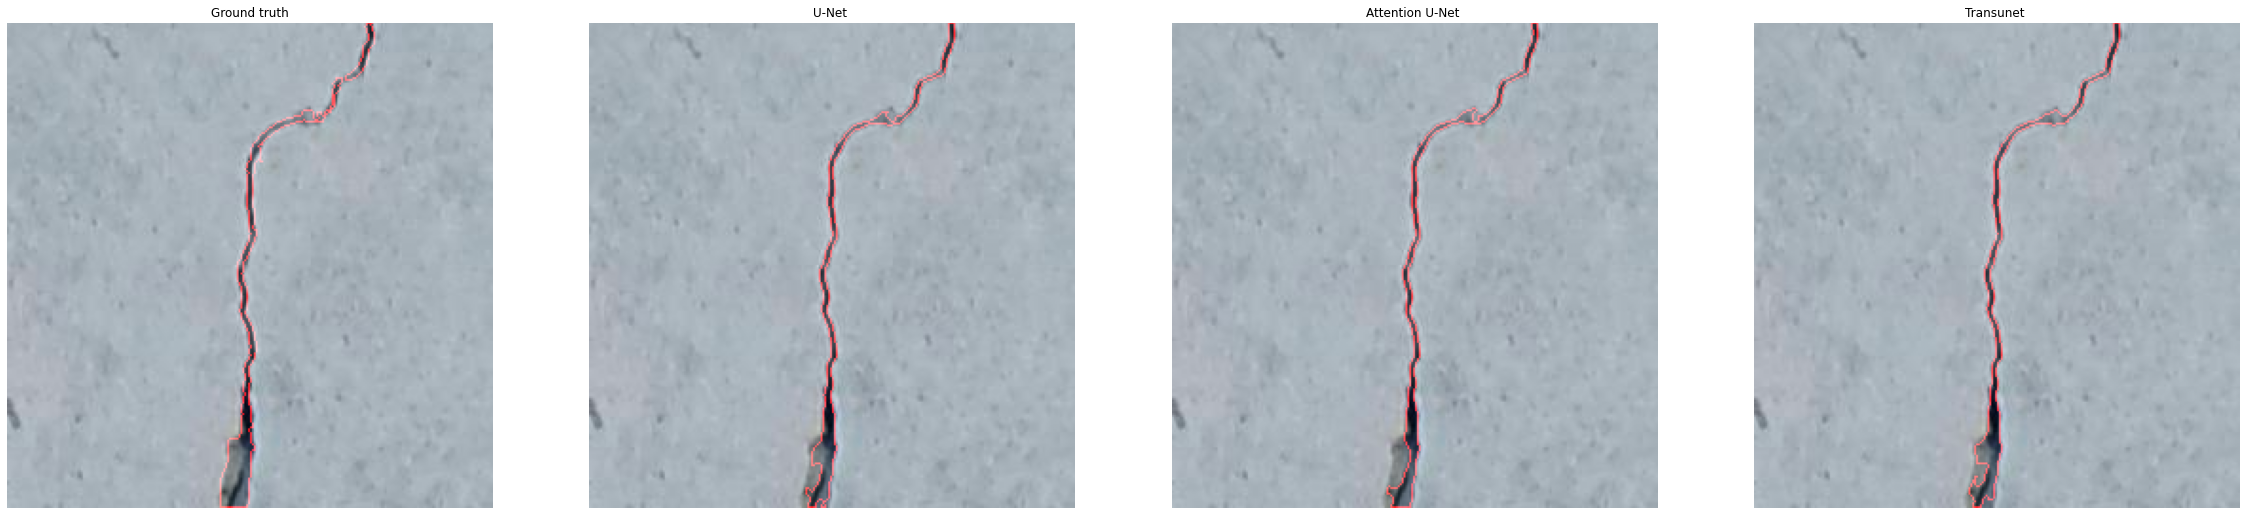

In [ ]:
print(f"analyzing image number: {image_number}")
threshold = 0.5


#load ground-truth image
gt_contour_gray, gt_contour_rgb = get_boundary(ground_truth.astype(np.uint8), 255, (255,0,0))

#U-Net 
unet_contour_gray, unet_contour_rgb = get_boundary(unet_prediction, 255, (255,0,0))
#Attention U-Net 
attunet_contour_gray, attunet_contour_rgb = get_boundary(attunet_prediction, 255, (255,0,0))
#TransUnet 
transunet_contour_gray, transunet_contour_rgb = get_boundary(transunet_prediction, 255, (255,0,0))


plt.figure(figsize=(40, 30))

plt.subplot(141)
plt.axis('off')
plt.title('Ground truth')
plt.imshow(gt_contour_rgb + image)
plt.subplot(142)
plt.axis('off')
plt.title('U-Net ')
plt.imshow(unet_contour_rgb+ image)
plt.subplot(143)
plt.axis('off')
plt.title('Attention U-Net ')
plt.imshow(attunet_contour_rgb+ image)
plt.subplot(144)
plt.axis('off')
plt.title('Transunet ')
plt.imshow(transunet_contour_rgb+ image)


## Boundary and fill

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


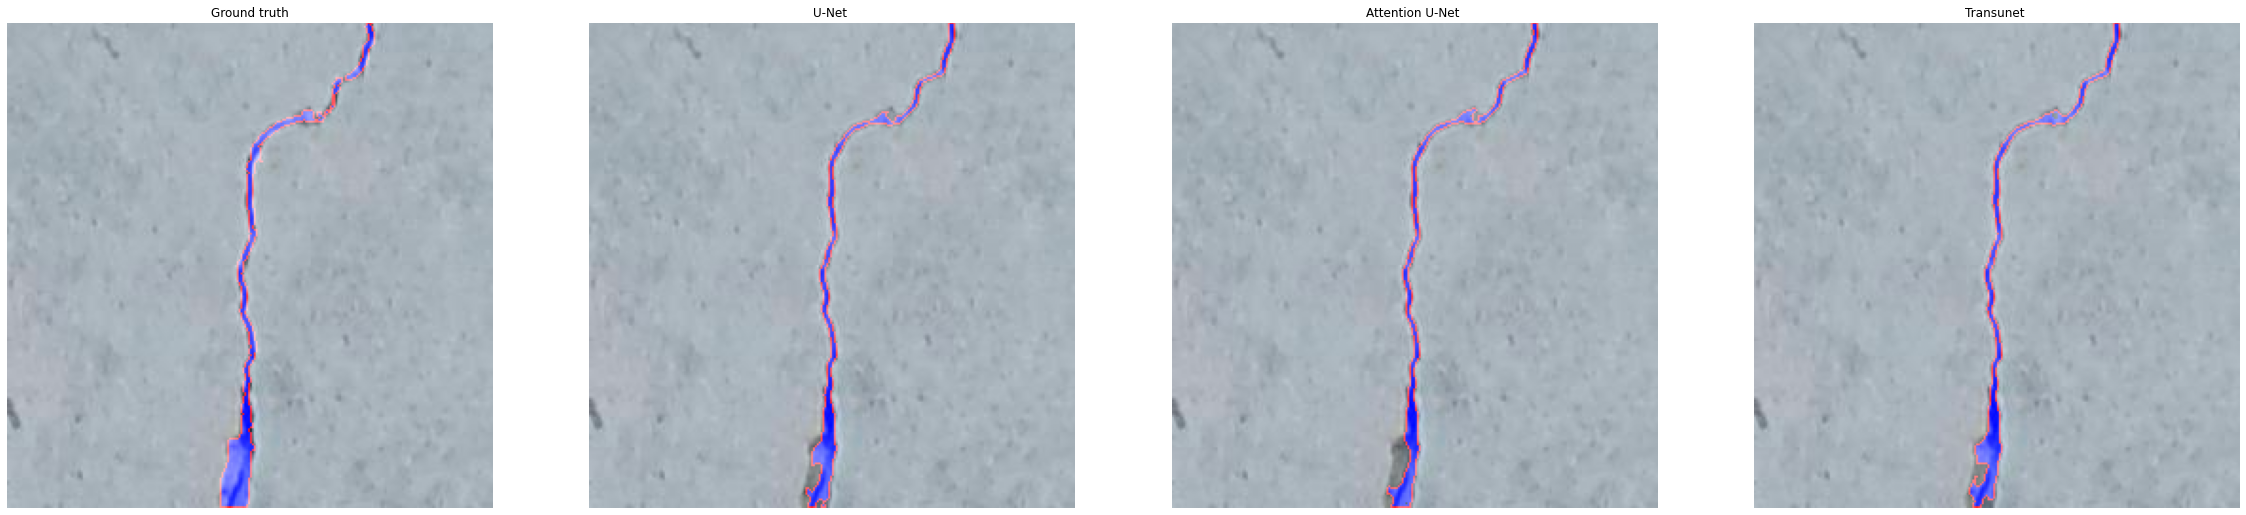

In [ ]:
plt.figure(figsize=(40, 30))

gt_border_value = (255,0,0)
gt_mask_value  = (0,0,255)

border_value = (255,0,0)
mask_value  = (0,0,255)

plt.subplot(141)
plt.axis('off')
plt.title('Ground truth')
plt.imshow(image + color_mask_with_boundary(ground_truth.astype(np.uint8), gt_mask_value, gt_border_value))
plt.subplot(142)
plt.axis('off')
plt.title('U-Net ')
plt.imshow(image + color_mask_with_boundary(unet_prediction, mask_value, border_value))
plt.subplot(143)
plt.axis('off')
plt.title('Attention U-Net ')
plt.imshow(image + color_mask_with_boundary(attunet_prediction, mask_value, border_value))
plt.subplot(144)
plt.axis('off')
plt.title('Transunet ')
plt.imshow(image + color_mask_with_boundary(transunet_prediction, mask_value, border_value))

## Pixel difference

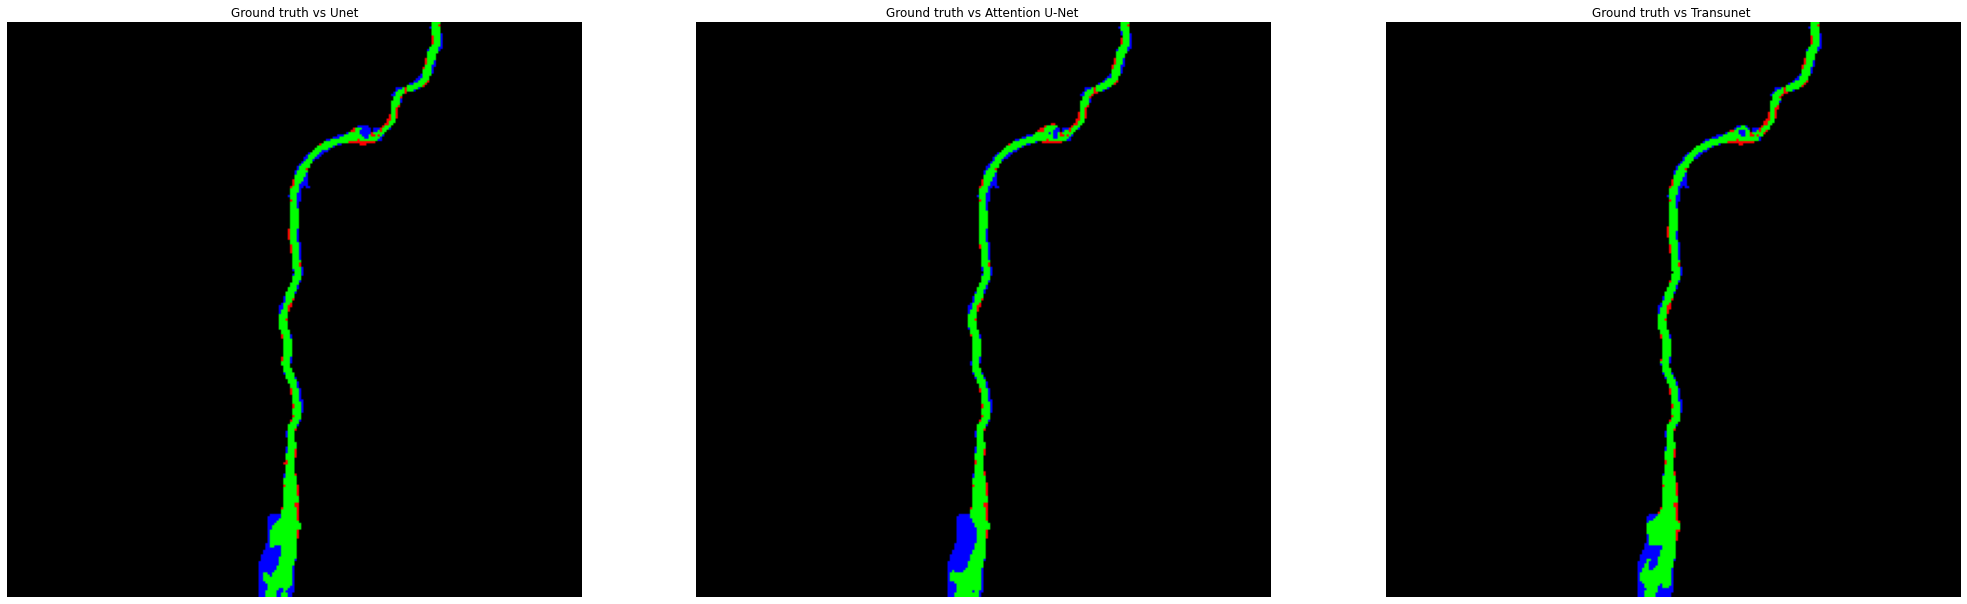

In [ ]:
plt.figure(figsize=(35, 35))

plt.subplot(131)
plt.axis('off')
plt.title('Ground truth vs Unet')
plt.imshow(pixel_map(ground_truth.astype(np.uint8), unet_prediction))
plt.subplot(132)
plt.axis('off')
plt.title('Ground truth vs Attention U-Net ')
plt.imshow(pixel_map(ground_truth.astype(np.uint8), attunet_prediction))
plt.subplot(133)
plt.axis('off')
plt.title('Ground truth vs Transunet ')
plt.imshow(pixel_map(ground_truth.astype(np.uint8), transunet_prediction))

# MEASUREMENT PLOTS

## utils

In [ ]:
# crack instance segment

def instance_segment(np_image): 
  # get crack
  # im_original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  rgb_original = cv2.cvtColor(np_image, cv2.COLOR_GRAY2RGB)  # rgb just for demo purpose
  if len(np.unique(np_image)) == 1:
    # print("no crack")
    return np_image, 0

  labeled = label(np_image, background=0)
  pixel_values = np.unique(labeled)
  cracks = [np.where(labeled != label, 0, labeled) for label in pixel_values]
  # del cracks[0]

  return cracks

In [ ]:
from skimage.morphology import skeletonize
def filter_crack_instances(cracks, np_image):

  instances = []
  for crack_instance in cracks:
      im = crack_instance.astype(np.uint8) * 255
      rgb = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)  # rgb just for demo purpose
      _, crack = cv2.threshold(im, 50, 255, cv2.THRESH_BINARY)

      # get medial axis
      med_plot = np.zeros((256,256), np.uint8)
      medial, distance = medial_axis(im, return_distance=True)
      med_img = img_as_ubyte(medial)
      med_contours, _ = cv2.findContours(med_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
      cv2.drawContours(med_plot, med_contours, -1, (255, 0, 0), 1)
      med_pts = [v[0] for v in med_contours[0]]

      # get point with maximal distance from medial axis
      max_idx = np.argmax(distance)
      max_pos = np.unravel_index(max_idx, distance.shape)
      max_dist = distance[max_pos]
      coords = np.array([max_pos[1], max_pos[0]])
      # print(f"max distance from medial axis to boundary = {max_dist} at x,y: {coords}")

      border_values = {0, 256}
      if coords[1] in border_values or coords[0] in border_values:
        continue

      # interpolate orthogonal of medial axis at coords
      delta = 150
      try:
          idx = next(i for i, v in enumerate(med_pts) if (v == coords).all())
      except StopIteration:
          continue

      px1, py1 = med_pts[(idx-delta) % len(med_pts)]
      px2, py2 = med_pts[(idx+delta) % len(med_pts)]
      orth = np.array([py1 - py2, px2 - px1]) * max(im.shape)
      # intersect orthogonal with crack and get contour
      orth_img = np.zeros(im.shape, dtype=np.uint8)
      A = tuple(coords + orth)
      B = tuple(coords - orth)
      cv2.line(orth_img, A, B, color=255, thickness=1)
      gap_img = cv2.bitwise_and(orth_img, crack)

      gap_contours, _ = cv2.findContours(gap_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      gap_pts = [v[0] for v in gap_contours[0]]

      if len(gap_pts) == 1:
        # print("here3")
        continue

      # determine the end points of the gap contour by negative dot product
      n = len(gap_pts)
      gap_ends = [
      p for i, p in enumerate(gap_pts)
      if np.dot(p - gap_pts[(i-1) % n], gap_pts[(i+1) % n] - p) < 0
      ]
      # print(f"Maximum gap found from {gap_ends[0]} to {gap_ends[1]}")

      C = tuple(gap_ends[0])
      D = tuple(gap_ends[1])
      distance = round(calculate_euclidean_distance(C,D),3)
      instances.append([[C,D], distance])
      
  return instances

In [ ]:
def calculate_euclidean_distance(p1,p2):
  s1 = (math.pow(p1[0] - p2[0],2))
  s2 = (math.pow(p1[1] - p2[1],2))
  euclidean_distance = math.sqrt(s1+s2)
  return euclidean_distance

In [ ]:

def get_boundary(numpy_img, pixel_value):
  canny_Img = cv2.Canny(numpy_img,100,200)
  contours,_ = cv2.findContours(canny_Img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  canvas = np.zeros_like(numpy_img)
  boundary = cv2.drawContours(canvas , contours, -1, pixel_value, 1)
  return boundary

In [ ]:
def crack_measurement(np_image): 
  # get crack
  # im_original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  rgb_original = cv2.cvtColor(np_image, cv2.COLOR_GRAY2RGB)  # rgb just for demo purpose
  if len(np.unique(np_image)) == 1:
    # print("no crack")
    return np_image, 0

  labeled = label(np_image, background=0)
  pixel_values = np.unique(labeled)
  cracks = [np.where(labeled != label, 0, labeled) for label in pixel_values]
  del cracks[0]

  crack_list = filter_crack_instances(cracks, np_image)

  if crack_list == []:
    return np_image, 0

  crack_line_points = []
  d = 0
  for crack_prop in crack_list:
    if crack_prop[1] > d:
      d = crack_prop[1] 
      crack_line_points = crack_prop[0]

  crack_line = np.zeros((256,256,3), np.uint8)
  crack_line = cv2.line(crack_line, crack_line_points[0], crack_line_points[1], color=(255, 0, 0), thickness=2)

  rgb_original = cv2.line(rgb_original, crack_line_points[0], crack_line_points[1], color=(0, 0, 255), thickness=2)
  text = str(d) + "px"
  rgb_original = cv2.putText(rgb_original, text, (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)


  return rgb_original, d, crack_line

In [ ]:
def get_boundary_w_gap(image, crack_line, rgb_value):
  im = image.astype(np.uint8) * 255
  _, crack = cv2.threshold(im, 50, 255, cv2.THRESH_BINARY)

  rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # rgb just for demo purpose
  contour_plot_rgb = np.zeros((256,256,3), np.uint8)
  contour_rgb, _ = cv2.findContours(crack, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  cv2.drawContours(contour_plot_rgb, contour_rgb, -1, rgb_value, 1)

  return contour_plot_rgb + crack_line

In [ ]:
def crack_measurement_all(np_image): 
  # get crack
  # im_original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  rgb_original = cv2.cvtColor(np_image, cv2.COLOR_GRAY2RGB)  # rgb just for demo purpose
  if len(np.unique(np_image)) == 1:
    # print("no crack")
    return np_image, 0

  labeled = label(np_image, background=0)
  pixel_values = np.unique(labeled)
  cracks = [np.where(labeled != label, 0, labeled) for label in pixel_values]
  del cracks[0]

  crack_list = filter_crack_instances(cracks, np_image)

  if crack_list == []:
    return np_image, 0

  crack_properties = {}
  max_dist = 0
  i = 1
  for crack_prop in crack_list:
    d = crack_prop[1] 
    crack_line_points = crack_prop[0]
    rgb_original = cv2.line(rgb_original, crack_line_points[0], crack_line_points[1], color=(0, 0, 255), thickness=2)
    text = str(d) + "px"
    rgb_original = cv2.putText(rgb_original, text, (crack_line_points[0][0]+10, crack_line_points[0][1]+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

    crack_properties[i] = {
        "start": crack_line_points[0],
        "end": crack_line_points[1],
        "distance": d
    }

    if d > max_dist:
      max_dist = d

    i = i+1

  return rgb_original, max_dist

## Visualize

analyzing image number: 77
Ground truth measurement: 18.868
Unet measurement: 18.358
Attention U-Net measurement: 18.868
Transunet measurement: 19.416


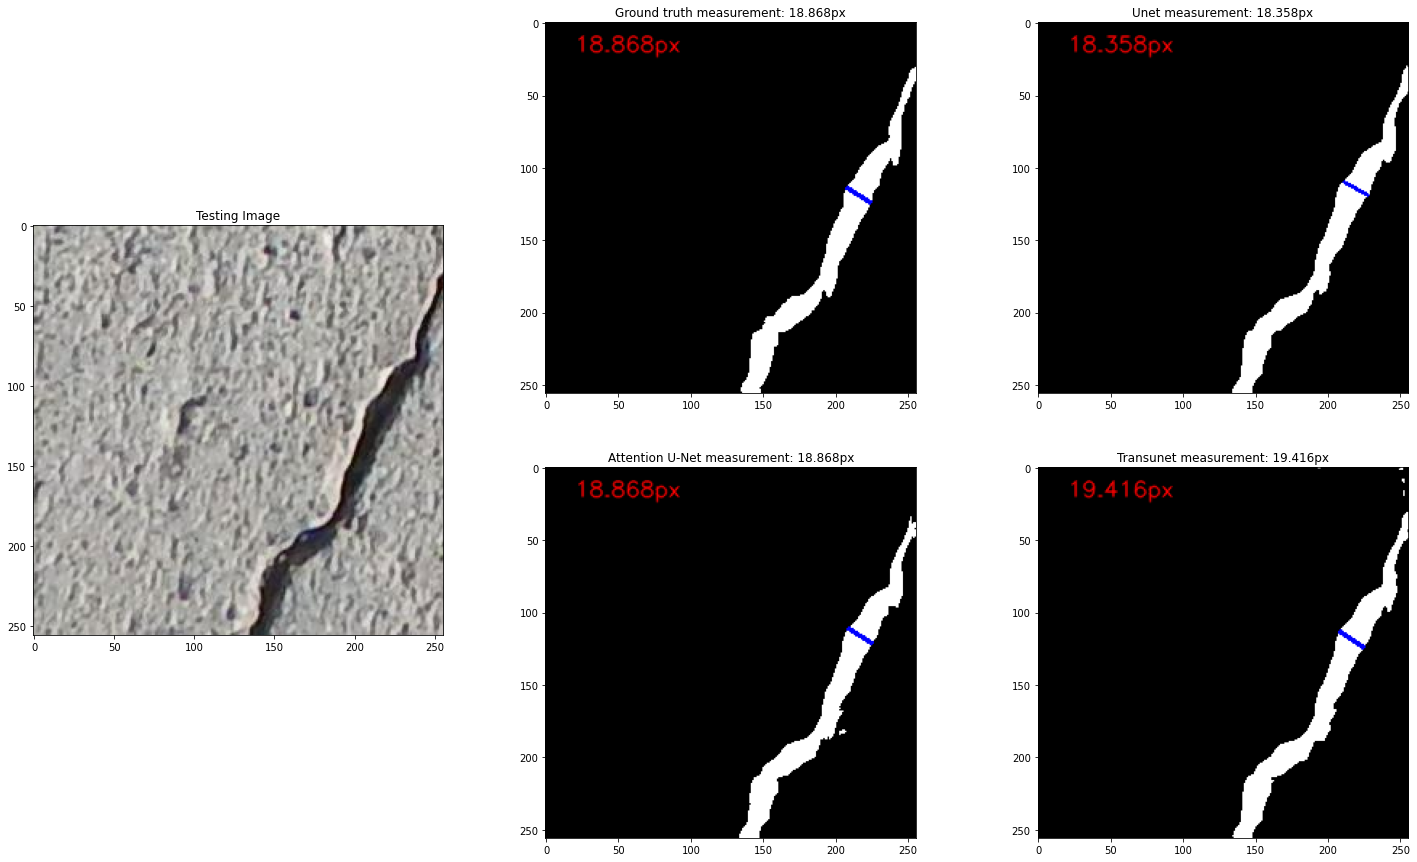

In [ ]:
image_number = random.randint(0, len(mask_dataset)-1)
print(f"analyzing image number: {image_number}")
#original image

#load ground-truth image
image = np.reshape(image_dataset[image_number], (256,256,3))
ground_truth = np.reshape(mask_dataset[image_number], (256,256))
ground_truth_measurement, ground_truth_distance, cl_gt  = crack_measurement(ground_truth.astype(np.uint8) * 255)


#Unet
unet_prediction = (models["unet"].predict(np.expand_dims(image, 0))[0,:,:,0] > threshold).astype(np.uint8)
unet_measurement, unet_distance, cl_unet = crack_measurement(unet_prediction.astype(np.uint8) * 255)
#Attention U-Net 
attunet_prediction = (models["att_unet"].predict(np.expand_dims(image, 0))[0,:,:,0] > threshold).astype(np.uint8)
attunet_measurement, attunet_distance, cl_attunet = crack_measurement(attunet_prediction.astype(np.uint8) * 255)
#TransUnet 
transunet_prediction = (models["trans_unet"].predict(np.expand_dims(image, 0))[0,:,:,0] > threshold).astype(np.uint8)
transunet_measurement, transunet_distance, cl_transunet = crack_measurement(transunet_prediction.astype(np.uint8) * 255)


print(f"Ground truth measurement: {ground_truth_distance}")
print(f"Unet measurement: {unet_distance}")
print(f"Attention U-Net measurement: {attunet_distance}")
print(f"Transunet measurement: {transunet_distance}")

plt.figure(figsize=(25, 15))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(image, cmap='gray')
plt.subplot(232)
plt.title(f'Ground truth measurement: {ground_truth_distance}px')
plt.imshow(ground_truth_measurement, cmap='gray')
plt.subplot(233)
plt.title(f'Unet measurement: {unet_distance}px')
plt.imshow(unet_measurement, cmap='gray')

plt.subplot(235)
plt.title(f'Attention U-Net measurement: {attunet_distance}px')
plt.imshow(attunet_measurement, cmap='gray')
plt.subplot(236)
plt.title(f'Transunet measurement: {transunet_distance}px')
plt.imshow(transunet_measurement, cmap='gray')

## Image and crack line

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


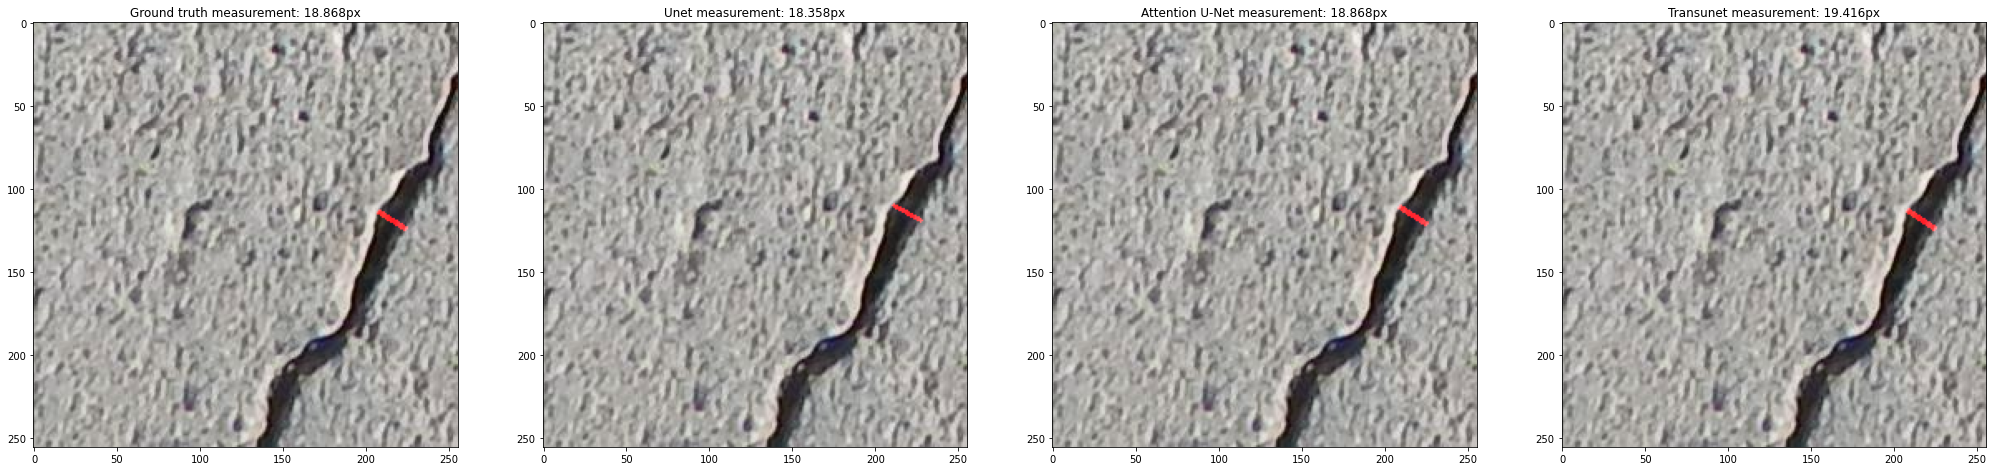

In [ ]:
plt.figure(figsize=(35, 35))
plt.subplot(141)
plt.title(f'Ground truth measurement: {ground_truth_distance}px')
plt.imshow(image + cl_gt, cmap='gray')
plt.subplot(142)
plt.title(f'Unet measurement: {unet_distance}px')
plt.imshow(image + cl_unet, cmap='gray')
plt.subplot(143)
plt.title(f'Attention U-Net measurement: {attunet_distance}px')
plt.imshow(image + cl_attunet, cmap='gray')
plt.subplot(144)
plt.title(f'Transunet measurement: {transunet_distance}px')
plt.imshow(image + cl_transunet, cmap='gray')

analyzing image number: 46


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


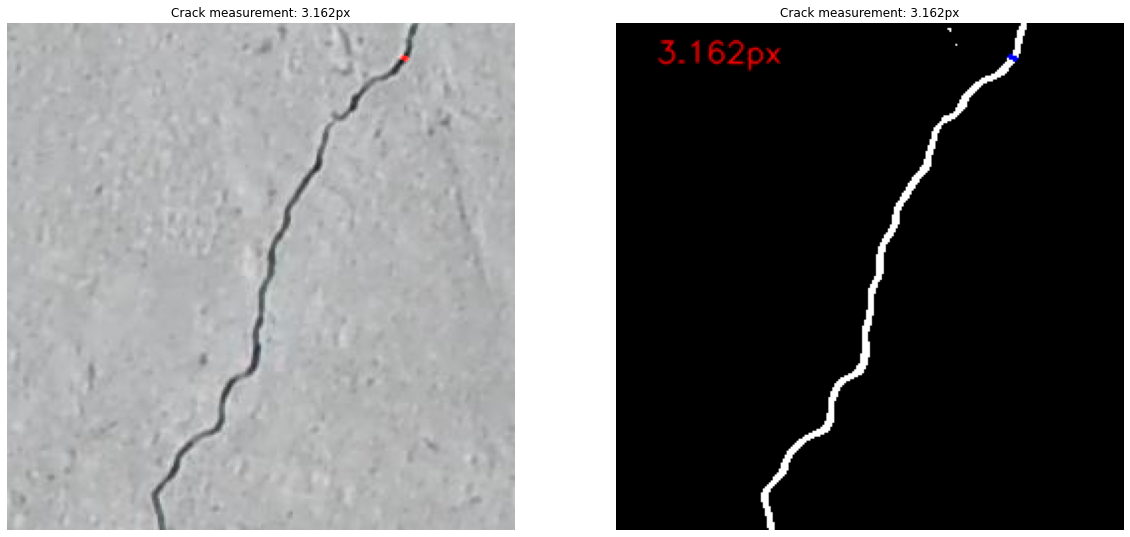

In [ ]:
image_number = random.randint(0, len(mask_dataset)-1)
print(f"analyzing image number: {image_number}")
#original image

#load ground-truth image
image = np.reshape(image_dataset[image_number], (256,256,3))
ground_truth = np.reshape(mask_dataset[image_number], (256,256))
#TransUnet 
transunet_prediction = (models["trans_unet"].predict(np.expand_dims(image, 0))[0,:,:,0] > threshold).astype(np.uint8)
transunet_measurement, transunet_distance, cl_transunet = crack_measurement(transunet_prediction.astype(np.uint8) * 255)


plt.figure(figsize=(20, 20))
plt.subplot(121)
plt.axis('off')
plt.title(f'Crack measurement: {transunet_distance}px')
plt.imshow(image + cl_transunet, cmap='gray')
plt.subplot(122)
plt.axis('off')
plt.title(f'Crack measurement: {transunet_distance}px')
plt.imshow(transunet_measurement, cmap='gray')

## Boundary and crack line

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


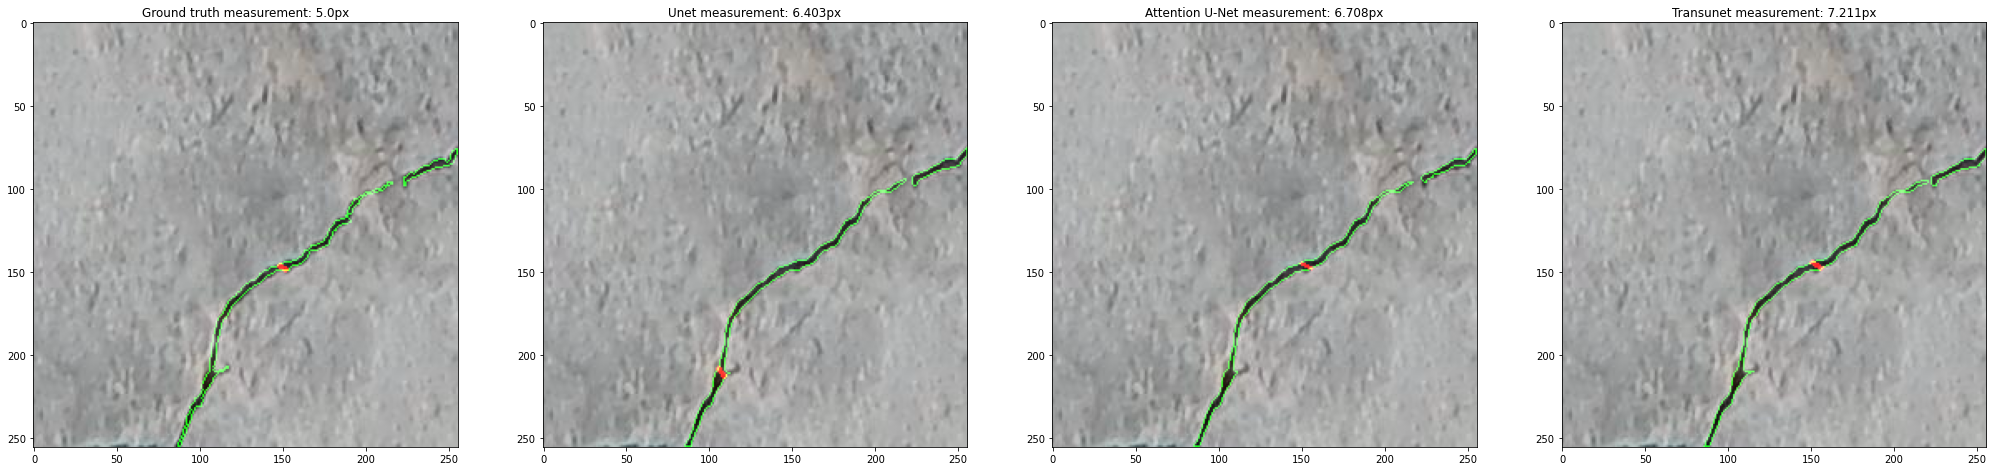

In [ ]:
#Ground truth
gt_boundary_crackline = get_boundary_w_gap(ground_truth.astype(np.uint8), cl_gt, (0,255,0))
#Unet
unet_boundary_crackline = get_boundary_w_gap(unet_prediction, cl_unet, (0,255,0))
#Attention U-Net 
attunet_boundary_crackline = get_boundary_w_gap(attunet_prediction, cl_attunet, (0,255,0))
#Transunet
transunet_boundary_crackline = get_boundary_w_gap(transunet_prediction, cl_transunet, (0,255,0))


plt.figure(figsize=(35, 35))
plt.subplot(141)
plt.title(f'Ground truth measurement: {ground_truth_distance}px')
plt.imshow(image + gt_boundary_crackline, cmap='gray')
plt.subplot(142)
plt.title(f'Unet measurement: {unet_distance}px')
plt.imshow(image + unet_boundary_crackline, cmap='gray')
plt.subplot(143)
plt.title(f'Attention U-Net measurement: {attunet_distance}px')
plt.imshow(image + attunet_boundary_crackline, cmap='gray')
plt.subplot(144)
plt.title(f'Transunet measurement: {transunet_distance}px')
plt.imshow(image + transunet_boundary_crackline, cmap='gray')